# Import libraries

In [ ]:
#pip install psycopg2
#pip install unidecode
#pip install nltk

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psycopg2

import re
import string
from unidecode import unidecode

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

from collections import Counter

In [ ]:
# To download once
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Connection to the postgreSQL database

In [ ]:
# connect to the database
conn = psycopg2.connect(
    host = "prod-rds-db.cbijryjiwdgw.eu-west-3.rds.amazonaws.com",
    user = "testdata",
    password = "testData678341A",
    database = "prodkbdb",
    port = "5432"
)

cur = conn.cursor()  # create a cursor

cur.execute("SELECT * FROM items")  # execute a query

# put the result of the query in a dataframe
column_names = ["id1", "amount", "description", "date", "itemName", "parent", "quantity", "taxAmount", "taxDescription", "type", "id2", "timestamp1", "timestamp2", "column13"]
df = pd.DataFrame(data=cur.fetchall(), columns=column_names)

# close the cursor and the connection
cur.close()
conn.close()

In [ ]:
df.head(10)

,id1,amount,description,date,itemName,parent,quantity,taxAmount,taxDescription,type,id2,timestamp1,timestamp2,column13
0,f22afa7a-5999-4d15-a218-17ac7d302cb9,3.00,,None,oeuf bio le cluzel,None,None,0.16,TVA 5.5 %,,e85e7339-9a06-4138-98ee-80a8801cd906,2023-05-13 08:17:07.161000+00:00,2023-05-13 08:17:07.161000+00:00,550
1,c385afb4-7b91-4f71-9ad9-140251349120,1.80,,None,joker xl,None,None,0.10,TVA 5.5 %,,0db7bcc2-1f04-434d-8ae5-cb4ee7c9d0a0,2023-05-13 08:17:27.570000+00:00,2023-05-13 08:17:27.570000+00:00,550
2,aafce9a2-f442-4386-a720-14307f51eacd,4.91,,None,pastille,None,None,0.82,TVA 20 %,,1468cce9-221f-4ff1-9bab-9d0425e755e0,2023-05-13 08:18:09.403000+00:00,2023-05-13 08:18:09.403000+00:00,2000
3,858b412a-deb0-4635-a69f-f29948451a3b,3.30,picodon aop - lait cru,None,picodon fermier aop,None,None,0.18,TVA 5.5 %,,9d3e7bdd-553b-4a3c-a594-b323de2ee609,2023-05-13 08:18:15.308000+00:00,2023-05-13 08:18:15.308000+00:00,550
4,f51bb24d-6b91-4709-b673-c8be69f2e142,2.00,,None,tomates pelées luce 240g,None,None,0.21,TVA 5.5 %,,512ca431-d4cc-465f-90c0-00f7d66927c8,2023-05-13 08:20:12.825000+00:00,2023-05-13 08:20:12.825000+00:00,550
5,cc3ecdf8-0b57-4598-a3a3-0b2d1d2bf1f0,1.90,,None,pdt agata vrac locale,None,None,0.15,TVA 5.5 %,,4b735449-d07c-46c0-b621-e5f94939c840,2023-05-13 08:20:23.826000+00:00,2023-05-13 08:20:23.826000+00:00,550
6,9dd8f499-586e-478a-ba15-e683bddc9b8f,0.50,,None,suppl. sirop,None,None,0.02,TVA 2.1 %,,35b7a668-7d30-4caf-b7e1-df1e0e423c07,2023-05-13 08:20:25.215000+00:00,2023-05-13 08:20:25.215000+00:00,210
7,ff84832e-e3ba-420f-b664-dc4f616ce9a0,6.50,,None,le proprianais,None,None,0.14,TVA 2.1 %,,233b8235-cd96-4303-af25-eb3a07a571d2,2023-05-13 08:20:46.308000+00:00,2023-05-13 08:20:46.308000+00:00,210
8,48570a3d-7ce3-49e2-93d0-e97dbae02be1,3.00,,None,flan,None,None,0.16,TVA 5.5 %,,036b92f5-eb77-463c-8e5b-121105fbd501,2023-05-13 08:20:50.557000+00:00,2023-05-13 08:20:50.557000+00:00,550
9,2b2256c0-8daf-4bb1-8aba-a6b1f8d204b0,1.46,,None,baguette graines,None,None,0.08,TVA 5.5 %,,e3203d4c-f4a0-4e11-a81b-aac9d89be688,2023-05-13 08:21:15.816000+00:00,2023-05-13 08:21:15.816000+00:00,550


We can see that there are several columns with *None* values and the dataset isn't labelled. So, in order to use a classification algorithm, we would need to manually label each row of the dataset which is too complicated, therefore we are going to use a clustering algorithm.

We will only be using the itemName column to perform the clustering.

In [ ]:
# drop unnecessary columns 
df.drop(["id1", "amount", "description", "date", "parent", "quantity", "taxAmount", "taxDescription", "type", "id2", "timestamp1", "timestamp2", "column13"], axis=1, inplace=True)
df.head(10)

,itemName
0,oeuf bio le cluzel
1,joker xl
2,pastille
3,picodon fermier aop
4,tomates pelées luce 240g
5,pdt agata vrac locale
6,suppl. sirop
7,le proprianais
8,flan
9,baguette graines


In [ ]:
print(df.shape)

(3904625, 1)


To reduce the size of the dataset, we remove duplicate rows (with the same item name).

In [ ]:
# drop duplicate rows
df = df.drop_duplicates(keep='first')
print(df.shape)

(107243, 1)


# Preprocessing

First, we need to remove unnecessary words and characters so that the words in our item names are meaningful for clustering later.

To do that, we create a function called preprocessing which cleans a string by:
- removing accents
- removing emojis
- removing punctuation
- removing numbers
- making words lowercase
- removing stopwords
- stemming words (shortening them to their root form)


In [ ]:
def preprocessing(text):
    """
    Performs the cleaning of a string
    Args: 
        text (string): the input text to clean
    Returns:
        text_cleaned (string): the cleaned text
    """   
    # remove accents
    text_cleaned = unidecode(text)
    
    # remove emojis from the text
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                "]+", flags=re.UNICODE)
    text_cleaned = emoji_pattern.sub(r'', text_cleaned)
    
    # remove punctuation
    for punc in string.punctuation:
        if punc in text:
            if punc == "-" or punc =="'":
                text_cleaned = text_cleaned.replace(punc, ' ')
            else:
                text_cleaned = text_cleaned.replace(punc, '')
    
    # remove digits
    text_cleaned = ''.join(c for c in text_cleaned if not c.isdigit())  
    
    # remove single letters
    text_cleaned = re.sub(r'\b\w\b', '', text_cleaned)

    # convert to lowercase and remove excessive whitespaces
    text_cleaned = text_cleaned.lower().strip()
    
    # tokenize and remove stop words
    tokens = word_tokenize(text_cleaned, language='french')
    stop_words = stopwords.words('french')
    stop_words += ['sans', 'ss', 'avec', 'petit', 'grand', 'moyen', 'simple', 'xl', 'maxi', 'double', 'cl', 'ml', 'gr', 'kg', 'cm', 'apres', 'svp']
    tokens = [word for word in tokens if word not in stop_words]
    text_cleaned = ' '.join(tokens)  # join back together
    
    # stemming
    stemmer_fr = SnowballStemmer(language='french')
    stemmed_fr = [stemmer_fr.stem(word) for word in word_tokenize(text_cleaned)]
    text_cleaned = ' '.join(stemmed_fr)
    
    stemmer_en = SnowballStemmer(language='english')
    stemmed_en = [stemmer_en.stem(word) for word in word_tokenize(text_cleaned)]
    text_cleaned = ' '.join(stemmed_en)
    
    return text_cleaned

Next, we apply this function to the entire dataframe and we add the cleaned item name series to our dataframe.

In [ ]:
# Apply the preprocessing function to the entire dataframe
df["cleaned_itemName"] = df["itemName"].apply(lambda x: preprocessing(x))
df.head(10)

,itemName,cleaned_itemName
0,oeuf bio le cluzel,oeuf bio cluzel
1,joker xl,jok
2,pastille,pastil
3,picodon fermier aop,picodon fermi aop
4,tomates pelées luce 240g,tomat pele luc
5,pdt agata vrac locale,pdt agat vrac local
6,suppl. sirop,suppl sirop
7,le proprianais,proprian
8,flan,flan
9,baguette graines,baguet grain


We end up with 26045 distinct words in total in the column *cleaned_itemName* of our dataframe.

In [ ]:
# Count the number of distinct words
all_words = ' '.join(df["cleaned_itemName"])  # concatenate all the words from the column
words = word_tokenize(all_words)  # tokenize the text into individual words
distinct_word_count = len(set(words))  # count the number of distinct words
print(distinct_word_count)

26045


# Train test split

We split the dataframe to leave some rows for future tests.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_test.shape)

(85794, 2)
(21449, 2)


# Vectorization

Now, we want to turn the cleaned text into numerical data so that we can perform the clustering. 

We use the TF-IDF vectorizer. TF-IDF measures the frequency of a word or a sequence of words in a document and compares it to the frequencies of all words in the text to assign it a weighted score of importance.

In [ ]:
# Vectorization
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))  # initialize the vectorizer
X_train = vectorizer.fit_transform(df_train["cleaned_itemName"])

# Mini-batch K-means clustering

We can now start the clustering.

K-means clustering is the most commonly used clustering algorithm. 

Here, in order to reduce computation costs, we will use Mini-batch K-means which is a modified version of K-means that uses small random batches of data instead of the whole dataset to update the clusters at each iteration.

## Optimal number of clusters

We can use the elbow method to test different values for K and compare the distances of each data point from their centroids (the sum of squarred errors).

We know that there are 26045 distinct words in all our item names, so we can't have more clusters than this number.

The more clusters we create, the lower the sum of squared errors (inertia) should be. A good model is one with low inertia and a low number of clusters K. 

The Elbow method consists in plotting the inertia as a function of the number of clusters and finding the point where the decrease in inertia begins to slow.

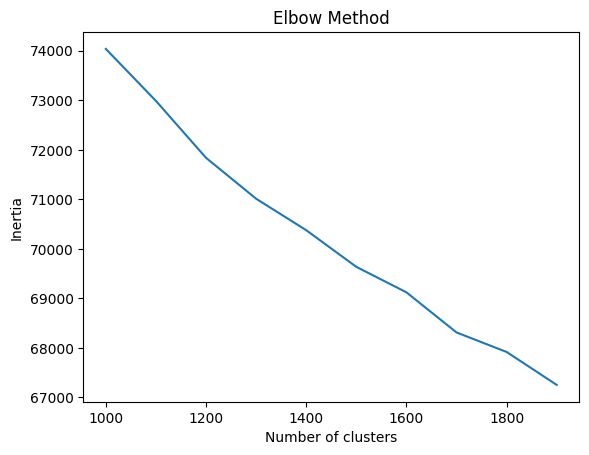

In [ ]:
# Find the optimal number of clusters using Elbow Method
inertia = []
for k in np.arange(1000, 2000, 100):
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
plt.plot(np.arange(1000, 2000, 100), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Because of limited memory, the number of clusters couldn't be increased more. 

We can see that the decrease in the inertia isn't getting smaller, so the optimal number of cluster is much higher than K=2000.

## Creating the clusters

Now, let's test the mini-batch K-means clustering algorithm with K=3000 (the highest number of clusters that can be handled by my computer).

In [ ]:
# Set the number of clusters
k = 3000 
# Fit our model
model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=10)
model.fit(X_train)

MiniBatchKMeans(n_clusters=3000, n_init=10)

In [ ]:
print(model.inertia_)

63374.68549640596


In [ ]:
# Store cluster labels
clusters = model.labels_

In [ ]:
# Add the column cluster to the dataframe df_train
df_train['cluster'] = clusters
df_train

,itemName,cleaned_itemName,cluster
189530,paleta loca,palet loc,480
311012,bière asahi 33cl 33 cl,bier asah,825
2341124,cube bouillon harira,cub bouillon har,1239
26629,parmesan galbani,parmesan galban,2975
1280492,seven up,seven up,190
...,...,...,...
1865407,panache 33,panach,973
241232,ring - offert fid,ring offert fid,702
16143,trilogie de glaces artisanales,trilog glac artisan,322
2473109,oztad gâteau salé aux sésames 300g,oztad gateau sal sesam,1479


## Cluster sizing

Let's look at the size of each cluster to assess the quality of the clustering.

In [ ]:
# Determine the size of each cluster
print(np.bincount(clusters))

[117 111  32 ...   3   5   2]


In [ ]:
# Count the number of empty clusters
print("Number of empty clusters :", list(np.bincount(clusters)).count(0))

# Count the number of clusters with only one element
print("Number of clusters with only one element :", list(np.bincount(clusters)).count(1))

Number of empty clusters : 92
Number of clusters with only one element : 255


There are 347 clusters out of 3000 with zero or one element (11.6%).

In [ ]:
# Determine the largest number of elements contained by a cluster
print("Max number of elements in a cluster :", max(np.bincount(clusters)))

Max number of elements in a cluster : 16122


There is one cluster with 16122 elements out of the 85794 rows in total (one cluster contains 18.8% of the data). It means that there is one very big cluster and that is not really what we are looking for. The clustering isn't optimal.

## Print the item names in each cluster

In [ ]:
# Print the item names in each cluster
for i in range(k):
    print(f"Cluster {i+1}:")
    cluster_items = df_train[clusters == i]["itemName"]
    print(cluster_items)
    print("-----------------------")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
413238       gusto mais creme onions  100g
2748                              il gusto
404047                        gusto poulet
404111                        gusto nature
883209                           p gustosa
40334                         gusto burger
405537                        gusto veggie
33872                    escalope il gusto
3057025           dolce gusto nesquik 256g
36608                                gusto
152394                        virgin gusto
2485193            gusto chips au mais 85g
2318212    gusto snacks de mais au sel 85g
Name: itemName, dtype: object
-----------------------
Cluster 2651:
31520                 salade st marcellin
107081                       le marcellin
1802655                   saint marcellin
8458                  saint marcellin igp
2602883             une sans st marcellin
3271823    st marcellin coulant + 2 autre
94667                   marcellin formule
2

## Cluster labels

Right now, our clusters are numbers between 0 and 2999. We can give our clusters labels for readability. We label each cluster with the two most frequent words that appear in all the item names of the cluster.

In [ ]:
# Label each cluster with the most frequent words
labels = []

for i in df_train['cluster'].unique():
    # get the item names for the current cluster
    subset = df_train[df_train['cluster'] == i]["cleaned_itemName"]
    cluster_itemnames = [subset.iloc[i] for i in range(len(subset))]

    # tokenize the item names and calculate word frequency
    words = [word for name in cluster_itemnames for word in word_tokenize(name)]
    word_freq = Counter(words)

    # find the most common words
    most_common_words = word_freq.most_common(2)

    # assign the most common words as the label for the cluster
    labels.append(' '.join([word for word, _ in most_common_words]))

In [ ]:
labels_df = pd.DataFrame(zip(df_train['cluster'].unique(), labels), columns=['cluster', 'label'])
labels_df

,cluster,label
0,480,palet breton
1,825,asah bier
2,1239,cub cp
3,2975,parmesan rap
4,190,up seven
...,...,...
2903,2170,unic pillchard
2904,1876,truffi
2905,1127,reclam pr
2906,801,bleu achel


We should note that some clusters don't have any elements, so they remain unlabelled.

In [ ]:
# Add the label column in our dataframe
df_train_labelled = pd.merge(df_train, labels_df, on='cluster', how='left')
df_train_labelled

,itemName,cleaned_itemName,cluster,label
0,paleta loca,palet loc,480,palet breton
1,bière asahi 33cl 33 cl,bier asah,825,asah bier
2,cube bouillon harira,cub bouillon har,1239,cub cp
3,parmesan galbani,parmesan galban,2975,parmesan rap
4,seven up,seven up,190,up seven
...,...,...,...,...
85789,panache 33,panach,973,panach
85790,ring - offert fid,ring offert fid,702,happi car
85791,trilogie de glaces artisanales,trilog glac artisan,322,glac artisan
85792,oztad gâteau salé aux sésames 300g,oztad gateau sal sesam,1479,coco saint


# Test our model

In [ ]:
def predict_category(item):
    """
    Predict the category of an item using our model
    Args: 
      item (string): the item to classify
    Returns:
      category (string): the category predicted by our model
    """   
    item = preprocessing(item)
    item_transformed = vectorizer.transform([item])
    num_cluster = model.predict(item_transformed)[0]
    if labels_df[labels_df['cluster'] == num_cluster].empty:
    category = 'unlabelled'
    else:
    category = labels_df[labels_df['cluster'] == num_cluster].iloc[0,1]
    return category

In [ ]:
for item in df_test["itemName"][:20]:
    print(item + " --> " + predict_category(item))

zpero --> verr menu
profruit pistaches en poudre 200g --> pistach glac
verre hares --> verr menu
pois chiches au naturel 720 ml --> poi chich
merci chef :) --> chef pizz
soda canette --> sod
mare gin --> mar min
lot de 3 saucissons --> sauc
foulard palma gres --> palm huil
manivelle 33cl c --> verr menu
guignolet 6 cl --> verr menu
tartine confiture --> confitur frai
lpb farila or/met 37 --> lpb moulu
1 mois juil/aout grande cabine --> grand boi
lpb cabat delinda craie --> lpb moulu
glace va2nille --> glac vanil
bouteille iso     500ml  albertineblanc d'ivoire --> verr menu
lok lac --> verr menu
aleo aloes vera 1.5 litres --> alo ver
delta q oalidus 10 cap --> cap bon
